In [37]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple test

In [38]:
#real_graph = nx.gnp_random_graph(100, 0.05)  # G(n,p) model with 100 nodes and a probability of edge creation of 0.05

real_graph = nx.watts_strogatz_graph(n=100, k=3, p=0.05)

In [39]:
# Simulate a logistic graph model (another random graph, for demonstration purposes)
logit_graph = nx.erdos_renyi_graph(n=100, p=0.05)

In [40]:
# Importing the necessary class
import src.model_selection as ms 

# Initialize the RandomGraphModelSelector
#selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)
selector = ms.GraphModelSelection(graph=real_graph,
                                  log_graph=logit_graph, log_params=[1,1,1], 
                                  models=["ER", "WS"],
                                  parameters=[{'lo': 0.01, 'hi': 0.1},
                                               {'lo': 0.01, 'hi': 0.1}]
                                  )

# Fit models and find the best model
#best_model, model_scores = selector.fit()

result = selector.select_model()
result

testing the selected model for ER
Model: ER, Parameters: {'lo': 0.01, 'hi': 0.1}
model function <function GraphModelSelection.model_function.<locals>.<lambda> at 0x28e22c4a0>
testing the selected model for WS
Model: WS, Parameters: {'lo': 0.01, 'hi': 0.1}
model function <function GraphModelSelection.model_function.<locals>.<lambda> at 0x28e21e0c0>


{'method': 'Graph Model Selection',
 'info': 'Selects the graph model that best approximates the observed graph.',
 'model': 'ER',
 'estimates': array([('ER', 0.02, 0.03305146), ('WS', 0.09, 7.02269121)],
       dtype=[('model', '<U10'), ('param', '<f8'), ('GIC', '<f8')])}

# Celegans

In [41]:
import graph_tool.all as gt
from graph_tool.all import *

model = "celegans_2019/male_gap_junction" # undirected graph fo C Elegans
g_celegans = gt.collection.ns[model]
g_celegans = np.array(adjacency(g_celegans).todense())

spec_g_celegans = graph.GraphModel.calculate_spectrum(g_celegans)

In [42]:
#est = estimator.LogitRegEstimator2(g_celegans)
est = estimator.LogitRegEstimator(g_celegans, d=10)
features, labels = est.get_features_labels()
result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
sigma = params[0]


result

/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.007     
Date:               2024-07-01 14:42 AIC:              19415.3632
No. Observations:   170853           BIC:              19445.5089
Df Model:           2                Log-Likelihood:   -9704.7   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      7.1252e-30
No. Iterations:     31.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -4.4339     0.0265   -167.3311   0.0000   -4.4859   -4.3820
x1      -0.0003     0.0001     -3.6145   0.0003   -0.0005   -0.0002
x2      -0.0009     0.0001     -8.2258   0.0000   -0.0012   -0.0007



In [43]:
results_real_net = []

for d in range(10):
    est = estimator.LogitRegEstimator(g_celegans, d=d)
    features, labels = est.get_features_labels()
    result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
    results_real_net.append(result.aic)

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.129     
Date:               2024-07-01 14:42 AIC:              17028.5539
No. Observations:   170853           BIC:              17058.6996
Df Model:           2                Log-Likelihood:   -8511.3   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     21.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -5.9648     0.0434   -137.4639   0.0000   -6.0498   -5.8797
x1       0.0843     0.0018     46.3981   0.0000    0.0808    0.0879
x2       0.0742     0.0019     38.4156   0.0000    0.0704    0.0780



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.127     
Date:               2024-07-01 14:42 AIC:              17070.9931
No. Observations:   170853           BIC:              17101.1388
Df Model:           2                Log-Likelihood:   -8532.5   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     21.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -5.8282     0.0428   -136.2860   0.0000   -5.9120   -5.7444
x1       0.0048     0.0001     43.2386   0.0000    0.0046    0.0050
x2       0.0042     0.0001     36.9931   0.0000    0.0040    0.0045



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.126     
Date:               2024-07-01 14:42 AIC:              17091.0400
No. Observations:   170853           BIC:              17121.1856
Df Model:           2                Log-Likelihood:   -8542.5   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     20.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -6.3092     0.0548   -115.0418   0.0000   -6.4167   -6.2017
x1       0.0013     0.0000     39.8406   0.0000    0.0013    0.0014
x2       0.0011     0.0000     30.9477   0.0000    0.0010    0.0012



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.081     
Date:               2024-07-01 14:42 AIC:              17960.7075
No. Observations:   170853           BIC:              17990.8532
Df Model:           2                Log-Likelihood:   -8977.4   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     22.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.4917     0.0710   -91.4021   0.0000   -6.6309   -6.3525
x1        0.0009     0.0000    30.8783   0.0000    0.0009    0.0010
x2        0.0006     0.0000    19.1124   0.0000    0.0005    0.0006



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.009     
Date:               2024-07-01 14:42 AIC:              19369.3961
No. Observations:   170853           BIC:              19399.5418
Df Model:           2                Log-Likelihood:   -9681.7   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      7.4331e-40
No. Iterations:     21.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -4.9564     0.0557   -88.9576   0.0000   -5.0656   -4.8472
x1        0.0004     0.0000    13.2917   0.0000    0.0003    0.0004
x2       -0.0000     0.0000    -0.6940   0.4877   -0.0001    0.0000



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.008     
Date:               2024-07-01 14:42 AIC:              19388.7094
No. Observations:   170853           BIC:              19418.8551
Df Model:           2                Log-Likelihood:   -9691.4   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      1.1615e-35
No. Iterations:     21.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -4.1510     0.0407   -102.0607   0.0000   -4.2307   -4.0713
x1      -0.0001     0.0000     -4.2467   0.0000   -0.0002   -0.0001
x2      -0.0004     0.0000    -11.3282   0.0000   -0.0005   -0.0003



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.017     
Date:               2024-07-01 14:42 AIC:              19224.7905
No. Observations:   170853           BIC:              19254.9362
Df Model:           2                Log-Likelihood:   -9609.4   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      2.9544e-71
No. Iterations:     31.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -4.0719     0.0350   -116.4638   0.0000   -4.1404   -4.0033
x1      -0.0005     0.0000    -10.3385   0.0000   -0.0006   -0.0004
x2      -0.0007     0.0001    -12.1295   0.0000   -0.0009   -0.0006



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.015     
Date:               2024-07-01 14:42 AIC:              19257.5402
No. Observations:   170853           BIC:              19287.6859
Df Model:           2                Log-Likelihood:   -9625.8   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      3.8192e-64
No. Iterations:     27.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -4.1979     0.0317   -132.6291   0.0000   -4.2600   -4.1359
x1      -0.0007     0.0001     -9.2182   0.0000   -0.0008   -0.0005
x2      -0.0010     0.0001    -10.5185   0.0000   -0.0012   -0.0008



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.011     
Date:               2024-07-01 14:42 AIC:              19328.6455
No. Observations:   170853           BIC:              19358.7912
Df Model:           2                Log-Likelihood:   -9661.3   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      1.0527e-48
No. Iterations:     30.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -4.3197     0.0291   -148.6681   0.0000   -4.3767   -4.2628
x1      -0.0005     0.0001     -6.0467   0.0000   -0.0007   -0.0004
x2      -0.0011     0.0001     -9.8028   0.0000   -0.0013   -0.0009



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.009     
Date:               2024-07-01 14:43 AIC:              19372.2212
No. Observations:   170853           BIC:              19402.3669
Df Model:           2                Log-Likelihood:   -9683.1   
Df Residuals:       170850           LL-Null:          -9771.8   
Converged:          1.0000           LLR p-value:      3.0524e-39
No. Iterations:     25.0000          Scale:            1.0000    
-------------------------------------------------------------------
         Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const   -4.3865     0.0274   -160.1143   0.0000   -4.4402   -4.3328
x1      -0.0004     0.0001     -4.5052   0.0000   -0.0006   -0.0002
x2      -0.0010     0.0001     -9.2824   0.0000   -0.0013   -0.0008



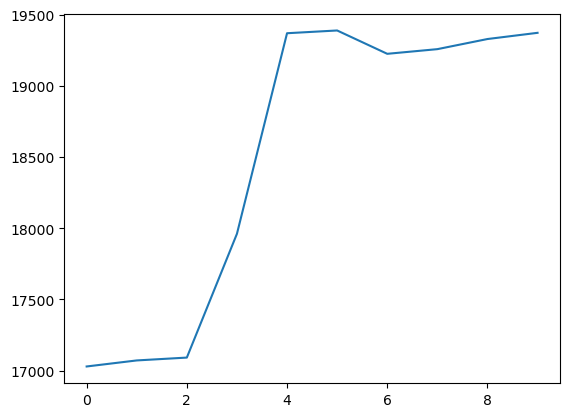

In [44]:
plt.figure()
plt.plot(results_real_net)
plt.show()

## Gen graph with the same parameters

In [55]:
n = g_celegans.shape[0]
d = 0
sigma = sigma
n_iteration = 20000
warm_up     = 10000

params_dict = {
    "n": n,
    "d": d,
    "sigma": sigma,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [56]:
graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
graphs, spec = graph_model.populate_edges( warm_up = warm_up, max_iterations = n_iteration, threshold = 5, stability_window = 10)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [57]:
ut = utils.GraphUtils()
#ut.saving_graph_artifacts(params_dict, graphs, spec)
#graphs, spec = ut.loading_graph_artifacts(params_dict)

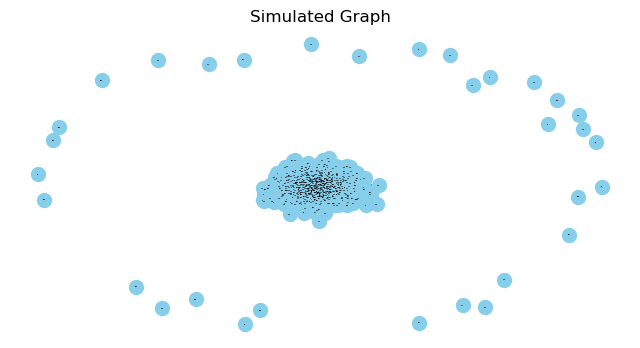

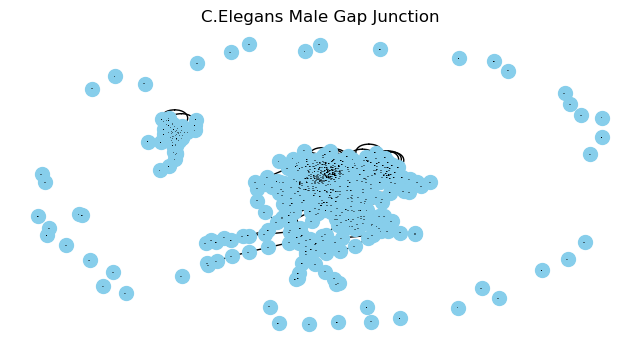

In [58]:
g = graphs[-1]
s = spec[-1]

fig1 = ut.plot_graph_from_adjacency(adj_matrix=g, pos=None, title='Simulated Graph', size=(8, 4), node_size=100, font_size=1)
fig2 = ut.plot_graph_from_adjacency(adj_matrix=g_celegans, pos=None, title='C.Elegans Male Gap Junction', size=(8, 4), node_size=100, font_size=1)

## Model Selection

### Arbitrary criterion

In [60]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans)
logit_graph = nx.from_numpy_array(g)

selector = ms.RandomGraphModelSelector(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


ER
For the Graph with 585 nodes and 1803 edges i get the following scores: ks_stat: 0.3299145299145299, cc_diff: 0.19843624482319885, aspl_diff: 0

WS
For the Graph with 585 nodes and 1170 edges i get the following scores: ks_stat: 0.4495726495726496, cc_diff: 0.2784698879803698, aspl_diff: 0

BA
For the Graph with 585 nodes and 3474 edges i get the following scores: ks_stat: 0.6547008547008547, cc_diff: 0.14581624020327405, aspl_diff: 0

LG
For the Graph with 585 nodes and 1523 edges i get the following scores: ks_stat: 0.04957264957264957, cc_diff: 0.18902868214526436, aspl_diff: 0

The best model is: LG
Model scores:
ER: 0.5283507747377287
WS: 0.7280425375530194
BA: 0.8005170949041287
LG: 0.23860133171791392


### Kl div criterion

In [61]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans)
logit_graph = nx.from_numpy_array(g)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


The best model is: LG
Model scores:
ER: 4.3141288763668735
WS: 13.66459186998385
BA: 30.73561012459235
LG: -1.1687212737600092


In [83]:
n_sim = 1000
results = []
for _ in range(n_sim):
    import src.model_selection as ms 
    real_graph = nx.from_numpy_array(g_celegans.toarray())
    logit_graph = nx.from_numpy_array(g)
    selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)
    best_model, model_scores = selector.fit()
    results.append(best_model)

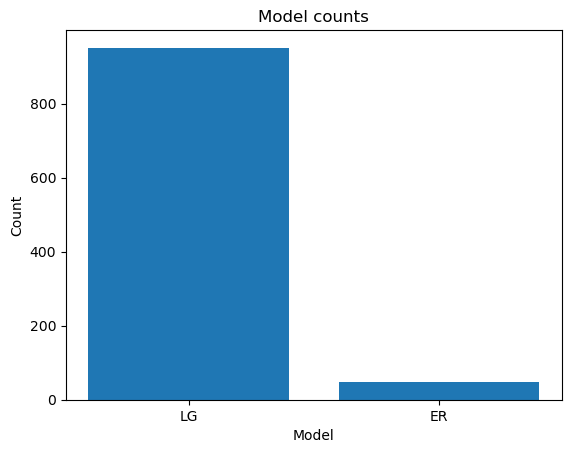

In [84]:
from collections import Counter

counts = Counter(results)

# Plot 
plt.bar(counts.keys(), counts.values())
plt.xlabel('Model')
plt.ylabel('Count')
plt.title('Model counts')
plt.show()

### Stat graph

In [75]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans)
logit_graph = nx.from_numpy_array(g)

selector = ms.GraphModelSelection(graph=real_graph,
                                  log_graph=logit_graph,
                                  log_params=sigma,
                                  models=["ER", "WS", "LG"],
                                  parameters=[{'lo': 0.01, 'hi': 0.3},
                                               {'lo': 0.01, 'hi': 0.3}]
                                  )

result = selector.select_model()

testing the selected model for ER
Model: ER, Parameters: {'lo': 0.01, 'hi': 0.3}
model function <function GraphModelSelection.model_function.<locals>.<lambda> at 0x2bb3b4180>


In [65]:
result

{'method': 'Graph Model Selection',
 'info': 'Selects the graph model that best approximates the observed graph.',
 'model': 'WS',
 'estimates': array([('WS', 0.28, 0.93096818), ('ER', 0.01, 0.93301997)],
       dtype=[('model', '<U10'), ('param', '<f8'), ('GIC', '<f8')])}